In [59]:
import pandas as pd
import os
import json
from pathlib import Path
import contextily as ctx
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import random

from pyincore import IncoreClient, DataService, HazardService, Dataset, FragilityService, MappingSet
from pyincore import HHRSOutputProcess

from pyincore.analyses.capitalshocks import CapitalShocks
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore.utils.dataprocessutil import DataProcessUtil
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability 
from pyincore.analyses.joplincge import JoplinCGEModel
from pyincore.analyses.housingrecoverysequential import HousingRecoverySequential
from pyincore.analyses.socialvulnerability import SocialVulnerability
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.utils.dataprocessutil import DataProcessUtil as util

2. Building Damage Analysis
The following steps are applied for analysis

2.1 IN-CORE Client and Services
2.2 Import Building data
2.3 Specify Hazard and Fragility
2.4 Setup and Run Damage analysis
2.5 Plot Results
2.6 Monte Carlo Simulation (MCS)

2.1 IN-CORE Client and Services

In [60]:
# Create IN-CORE client and connection to services
client = IncoreClient()
data_services = DataService(client)

Connection successful to IN-CORE services. pyIncore version detected: 1.18.0


2.2 Import Building data

In [61]:
building_dataset_id = "5dbc8478b9219c06dd242c0d"  # Load the Joplin building dataset.
buildings = Dataset.from_data_service(building_dataset_id, data_services)

archetype_mapping = "5fca92781ab3d87c35db1e54"

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


2.3 Specify Hazard and Fragility

In [62]:
hazard_type = "tornado"
hazard_id = "5d07cbeab9219c065b080930"  # The simulated EF-5 tornado shows geographical locations and the range
                                        # of wind speed of tornado hazard in Joplin.

fragility_service = FragilityService(client)
mapping_id = "5d8942dfb9219c068ea795ea" # Create a mapping to assign tornado fragilities to 19 building archetypes.
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

2.4 Setup and Run Damage analysis

In [63]:
# Analysis setup
result_name = "Joplin_bldg_dmg_result"

bldg_dmg = BuildingDamage(client)
bldg_dmg.set_input_dataset("buildings", buildings)
bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)
bldg_dmg.set_parameter("result_name", result_name)
bldg_dmg.set_parameter("hazard_type", hazard_type)
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("num_cpu", 4)

# Run building damage
bldg_dmg.run_analysis()

True

2.5 Plot analysis results

In [64]:
# Print out 5 records from the analysis results
bldg_dmg.get_output_dataset('ds_result').get_dataframe_from_csv().head()

,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
2,758fb3de-108a-4e04-895e-fdc4b8627876,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
3,7b706697-bf9b-4883-90f6-862d67a8e64b,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no


In [65]:
# Adding information from inputs into analysis results
bldg_dmg_df = bldg_dmg.get_output_dataset("ds_result").get_dataframe_from_csv()
bldg_gdf = buildings.get_dataframe_from_shapefile()

arch_mapping_ds = Dataset.from_data_service(archetype_mapping, data_services)
arch_mapping = arch_mapping_ds.get_dataframe_from_csv()

print(arch_mapping)

max_dmg_state_df = DataProcessUtil.get_max_damage_state(bldg_dmg_df)
print(max_dmg_state_df)

ret_json = DataProcessUtil.create_mapped_dmg_result(bldg_gdf, max_dmg_state_df, arch_mapping, "max_state", "archetype")
print(ret_json)

bldg_dmg_gdf = bldg_gdf[['guid', 'archetype','geometry']].merge(bldg_dmg_df, on='guid')
bldg_dmg_gdf.head()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
    archetype                category  \
0        12.0     Critical Facilities   
1        14.0     Critical Facilities   
2        11.0     Critical Facilities   
3         NaN     Critical Facilities   
4         NaN      Emergency Housing    
5         NaN      Emergency Housing    
6         NaN      Emergency Housing    
7         NaN  Housing / Neighborhood   
8        13.0  Housing / Neighborhood   
9         1.0  Housing / Neighborhood   
10        2.0  Housing / Neighborhood   
11        3.0  Housing / Neighborhood   
12        4.0  Housing / Neighborhood   
13        5.0  Housing / Neighborhood   
14       17.0  Housing / Neighborhood   
15        NaN  Housing / Neighborhood   
16        9.0  Housing / Neighborhood   
17       10.0  Housing / Neighborhood   
18        NaN  Housing / Neighborhood   
19        NaN  Housing / Neighborhood   
20        7.0  

,guid,archetype,geometry,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,1,POINT (-94.51719 37.09726),0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,1,POINT (-94.51716 37.09740),0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
2,758fb3de-108a-4e04-895e-fdc4b8627876,1,POINT (-94.51690 37.09756),0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
3,7b706697-bf9b-4883-90f6-862d67a8e64b,1,POINT (-94.51712 37.09755),0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,1,POINT (-94.51716 37.09768),0.0,0.0,0.0,1.0,0.0,0.0,0.0,no


2.6 Monte Carlo Simulation (MCS)

In [66]:
#### Obtain the building damage results
building_dmg_result = bldg_dmg.get_output_dataset('ds_result')

#### Convert the building damage results to dataframe
df_bldg_dmg = building_dmg_result.get_dataframe_from_csv()

df_bldg_dmg.head()

,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
2,758fb3de-108a-4e04-895e-fdc4b8627876,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
3,7b706697-bf9b-4883-90f6-862d67a8e64b,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,no


In [67]:
num_samples = 500 # Require 500 samples for convergence - Selected smaller samples for testing 
result_name = "Joplin_mc_failure_probability_buildings_dmg_result"

mc_bldg = MonteCarloFailureProbability(client)

mc_bldg.set_input_dataset("damage", building_dmg_result)
mc_bldg.set_parameter("num_cpu", 8)
mc_bldg.set_parameter("num_samples", num_samples)
mc_bldg.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3"])
mc_bldg.set_parameter("failure_state_keys", ["DS_2", "DS_3"])

mc_bldg.set_parameter("result_name", result_name) 

True

In [68]:
mc_bldg.run_analysis() 

# Obtain buildings failure probabilities
building_failure_probability = mc_bldg.get_output_dataset('failure_probability')  

df_bldg_fail = building_failure_probability.get_dataframe_from_csv()
df_bldg_fail.head()

,guid,failure_probability
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,0.0
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,0.0
2,758fb3de-108a-4e04-895e-fdc4b8627876,0.0
3,7b706697-bf9b-4883-90f6-862d67a8e64b,0.0
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,0.0


In [69]:
# Obtain buildings sample damage states
sample_damage_states = mc_bldg.get_output_dataset('sample_damage_states')  
df_bldg_ds = sample_damage_states.get_dataframe_from_csv()
df_bldg_ds.head()

,guid,sample_damage_states
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."
2,758fb3de-108a-4e04-895e-fdc4b8627876,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."
3,7b706697-bf9b-4883-90f6-862d67a8e64b,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,"DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,DS_0,D..."


In [70]:
building_damage_mcs_samples = mc_bldg.get_output_dataset('sample_failure_state')  # get buildings failure states

bdmcs = building_damage_mcs_samples.get_dataframe_from_csv()
bdmcs.head()

,guid,failure
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
2,758fb3de-108a-4e04-895e-fdc4b8627876,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
3,7b706697-bf9b-4883-90f6-862d67a8e64b,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."


In [71]:
ret_json = DataProcessUtil.create_mapped_func_result(bldg_gdf, 
                                                     bdmcs, 
                                                     arch_mapping, 
                                                     arch_col="archetype")
ret_json

{'by_cluster': [{'cluster': 'Critical Medical - Acute Care Hospitals',
   'category': 'Critical Facilities',
   'tot_count': 41.0,
   'num_functional': 29,
   'num_non_functional': 12,
   'percent_functional': 0.7073170732,
   'percent_non_functional': 0.2926829268},
  {'cluster': 'Emergency Operations Centers',
   'category': 'Critical Facilities',
   'tot_count': 28.0,
   'num_functional': 23,
   'num_non_functional': 5,
   'percent_functional': 0.8214285714,
   'percent_non_functional': 0.1785714286},
  {'cluster': 'Critical Government - First Responder Facilities',
   'category': 'Critical Facilities',
   'tot_count': 8.0,
   'num_functional': 7,
   'num_non_functional': 1,
   'percent_functional': 0.875,
   'percent_non_functional': 0.125},
  {'cluster': 'Non-ambulatory Facilities - Prisons, nursing homes, etc.',
   'category': 'Critical Facilities',
   'tot_count': -1.0,
   'num_functional': -1,
   'num_non_functional': -1,
   'percent_functional': -1.0,
   'percent_non_functiona

4. Electric Power Facility (EPF) Damage Analysis
The following steps are applied for analysis

4.1 Import Electric Power Substation data
4.2 Specify Electric Power Substation Fragility and Mapping
4.3 Setup and Run Electric Power Substation Damage analysis
4.4 Plot Results for Electric Power Substation
4.5 Monte Carlo Simulation (MCS) of Electric Power Substation
4.6 Import Electric Power Generation Plants data
4.7 Specify Electric Power Generation Plants Fragility and Mapping
4.8 Setup and Run Electric Power Generation Plants Damage analysis
4.9 Plot Results for Electric Power Generation Plants
4.10 Monte Carlo Simulation (MCS) of Electric Power Generation Plants

4.1 Import Electric Power Substation data

In [72]:
local_epf_ss = Dataset.from_data_service("5d92355bb9219c06ae7e386a", data_services)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


4.2 Specify Electric Power Substation Fragility and Mapping

In [73]:
# Fragility mapping
mapping_id = "5d8a326fb9219c068ea798e7"

4.3 Setup and Run Electric Power Substation Damage analysis

In [77]:
# Run epf damage 
eq_epf_ss_dmg = EpfDamage(client)
eq_epf_ss_dmg.set_input_dataset("epfs", local_epf_ss)

# Load fragility mapping
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
eq_epf_ss_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

True

In [79]:
result_name = "Joplin_epf_substations_dmg_result"
eq_epf_ss_dmg.set_parameter("result_name", result_name)
eq_epf_ss_dmg.set_parameter("hazard_type", hazard_type)
eq_epf_ss_dmg.set_parameter("hazard_id", hazard_id)
eq_epf_ss_dmg.set_parameter("num_cpu", 4)
eq_epf_ss_dmg.set_parameter("fragility_key", "substations")  # Define the result name, etc., and choose the number
                                                           # of CPU locally to run the model parallelly.

# Run Analysis
eq_epf_ss_dmg.run_analysis()

True

4.4 Plot Results for Electric Power Substation

In [80]:
epf_ss_dmg_df=eq_epf_ss_dmg.get_output_dataset('result').get_dataframe_from_csv()
epf_ss_dmg_df.head()

,guid,LS_0,LS_1,LS_2,LS_3,DS_0,DS_1,DS_2,DS_3,DS_4,haz_expose
0,7f426763-81c6-4cac-b98d-c37a5e439b90,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
1,fc8add00-6760-4752-b1fb-7d6ca813f535,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
2,e8f4939d-763f-4743-bc61-c23e0b8e0f7a,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
3,2cab48ff-c5ce-495e-9662-67c9a177efc4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no
4,eb4ce929-5164-4ebf-ace2-708096d89db5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no


Text(0, 0.5, 'Counts')

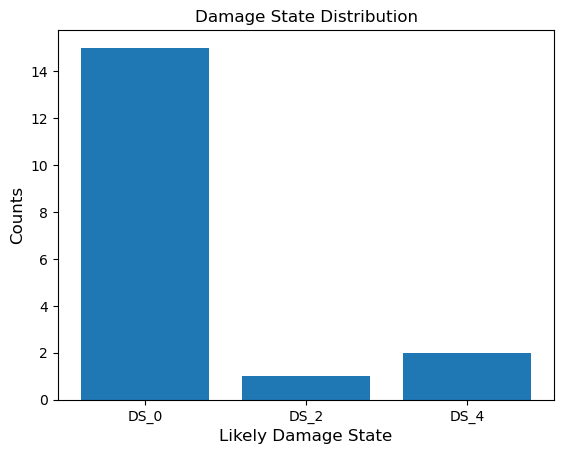

In [81]:
DSlist = np.array(['DS_0', 'DS_1', 'DS_2', 'DS_3', 'DS_4'])
spf_ss_likelyDS = DSlist[epf_ss_dmg_df.loc[:,['DS_0', 'DS_1', 'DS_2', 'DS_3','DS_4']].values.argmax(axis=1)]
epf_ss_dmg_df['likelyDS'] = spf_ss_likelyDS
keys, counts = np.unique(spf_ss_likelyDS, return_counts=True)

fig, ax = plt.subplots()
ax.bar(keys, counts)
ax.set_title("Damage State Distribution", fontsize=12)
ax.set_xlabel("Likely Damage State", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)

In [82]:
# Adding information from inputs into analysis results
epf_ss_gdf = local_epf_ss.get_dataframe_from_shapefile()
epf_ss_dmg_df = epf_ss_gdf[['guid', 'utilfcltyc','geometry']].merge(epf_ss_dmg_df, on='guid')
epf_ss_dmg_df.head()

,guid,utilfcltyc,geometry,LS_0,LS_1,LS_2,LS_3,DS_0,DS_1,DS_2,DS_3,DS_4,haz_expose,likelyDS
0,7f426763-81c6-4cac-b98d-c37a5e439b90,ESSL,MULTIPOINT ((-94.47707 37.05486)),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no,DS_0
1,fc8add00-6760-4752-b1fb-7d6ca813f535,ESSM,MULTIPOINT ((-94.45979 37.04915)),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no,DS_0
2,e8f4939d-763f-4743-bc61-c23e0b8e0f7a,ESSM,MULTIPOINT ((-94.47035 37.11595)),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no,DS_0
3,2cab48ff-c5ce-495e-9662-67c9a177efc4,ESSM,MULTIPOINT ((-94.51071 37.08971)),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no,DS_0
4,eb4ce929-5164-4ebf-ace2-708096d89db5,ESSM,MULTIPOINT ((-94.51047 37.08685)),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no,DS_0


In [83]:
# Statistic summary for DS_4 state
epf_ss_dmg_df["DS_4"].describe()

count    18.000000
mean      0.094466
std       0.274422
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.997562
Name: DS_4, dtype: float64

Text(0, 0.5, 'counts')

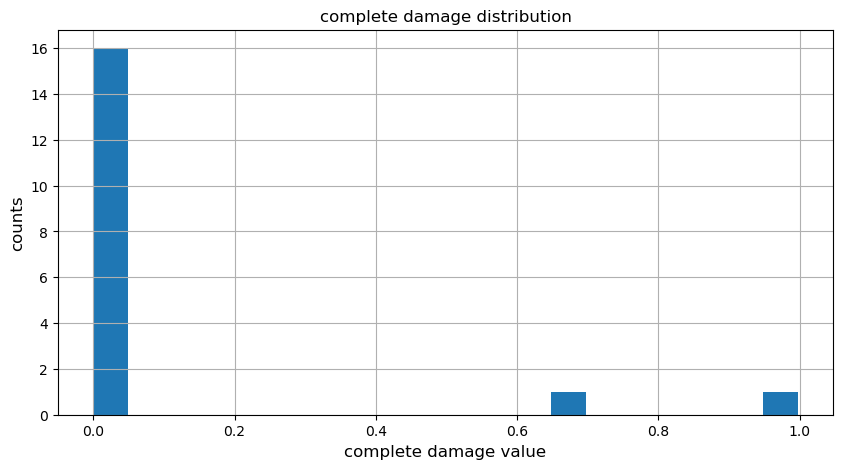

In [84]:
# Histogram plot for DS_4
ax = epf_ss_dmg_df['DS_4'].hist(bins=20, figsize=[10,5])
ax.set_title("complete damage distribution", fontsize=12)
ax.set_xlabel("complete damage value", fontsize=12)
ax.set_ylabel("counts", fontsize=12)

4.5 Monte Carlo Simulation (MCS) of Electric Power Substation

In [85]:
num_samples = 500
mc_sub = MonteCarloFailureProbability(client)

result_name = "Joplin_EPN_substations_mc_failure_probability"
substation_dmg_result=eq_epf_ss_dmg.get_output_dataset('result')

mc_sub.set_input_dataset("damage", substation_dmg_result)
mc_sub.set_parameter("num_cpu", 8)
mc_sub.set_parameter("num_samples", num_samples)
mc_sub.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3", "DS_4"])
mc_sub.set_parameter("failure_state_keys", ["DS_2", "DS_3", "DS_4"])

mc_sub.set_parameter("result_name", result_name) # name of csv file with results
mc_sub.run_analysis()

True

In [86]:
substation_failure_probability = mc_sub.get_output_dataset('failure_probability')  # get buildings failure probabilities

df_substation_fail = substation_failure_probability.get_dataframe_from_csv()
df_substation_fail.head()

,guid,failure_probability
0,7f426763-81c6-4cac-b98d-c37a5e439b90,0.0
1,fc8add00-6760-4752-b1fb-7d6ca813f535,0.0
2,e8f4939d-763f-4743-bc61-c23e0b8e0f7a,0.0
3,2cab48ff-c5ce-495e-9662-67c9a177efc4,0.0
4,eb4ce929-5164-4ebf-ace2-708096d89db5,0.0


In [87]:
substation_damage_mcs_samples = mc_sub.get_output_dataset('sample_failure_state')

sdmcs = substation_damage_mcs_samples.get_dataframe_from_csv()
sdmcs.head()

,guid,failure
0,7f426763-81c6-4cac-b98d-c37a5e439b90,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
1,fc8add00-6760-4752-b1fb-7d6ca813f535,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
2,e8f4939d-763f-4743-bc61-c23e0b8e0f7a,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
3,2cab48ff-c5ce-495e-9662-67c9a177efc4,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
4,eb4ce929-5164-4ebf-ace2-708096d89db5,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."


5. Physical Functionality Analysis

5.1. Functionality of Buildings and Substations

The MC samples from earlier subsection are used in this subsection to perform functionality analysis and determine the functionality state of each building. According to Almufti and Willford (2013), functionality is defined as the capacity of a component to serve its intended objectives consist of structural integrity, safety, and utilities (e.g., water and electricity). An individual building can be narrowly classified into five discrete states consist of the restricted entry (State 1), restricted use (State 2), preoccupancy (State 3), baseline functionality (State 4) and full functionality (State 5). In a broader classification, functionality states can be categorized into nonfunctional (States 1 to 3) and functional (States 4 and 5). This notebook relies on the latter broader classification approach to estimate the functionality state of each building and subsequently use functionality estimates to perfom functionality analysis by accounting for interdependency between buildings and lifeline networks (i.e., EPN)

In [90]:
depend_dict_id = "5dcf4a34b9219ca5e4118312"

bldg_func = BuildingFunctionality(client)

# Load the datasets of MC simulations for buildings
bldg_func.set_input_dataset("building_damage_mcs_samples", building_damage_mcs_samples)
bldg_func.set_input_dataset("substations_damage_mcs_samples", substation_damage_mcs_samples)
bldg_func.load_remote_input_dataset("interdependency_dictionary", depend_dict_id)

result_name = "Joplin_mcs_functionality_probability"
bldg_func.set_parameter("result_name", result_name)

True

In [91]:
### Run the BuildingFunctionality module to obtain the building functionality probabilities
bldg_func.run_analysis() 

bldg_func_samples = bldg_func.get_output_dataset('functionality_samples')
df_bldg_samples = bldg_func_samples.get_dataframe_from_csv()
df_bldg_samples.head()

,guid,failure
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
2,758fb3de-108a-4e04-895e-fdc4b8627876,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
3,7b706697-bf9b-4883-90f6-862d67a8e64b,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."


In [92]:
ret_json = DataProcessUtil.create_mapped_func_result(bldg_gdf, 
                                                     df_bldg_samples, 
                                                     arch_mapping, 
                                                     arch_col="archetype")
ret_json

{'by_cluster': [{'cluster': 'Critical Medical - Acute Care Hospitals',
   'category': 'Critical Facilities',
   'tot_count': 41.0,
   'num_functional': 3,
   'num_non_functional': 38,
   'percent_functional': 0.0731707317,
   'percent_non_functional': 0.9268292683},
  {'cluster': 'Emergency Operations Centers',
   'category': 'Critical Facilities',
   'tot_count': 28.0,
   'num_functional': 19,
   'num_non_functional': 9,
   'percent_functional': 0.6785714286,
   'percent_non_functional': 0.3214285714},
  {'cluster': 'Critical Government - First Responder Facilities',
   'category': 'Critical Facilities',
   'tot_count': 8.0,
   'num_functional': 7,
   'num_non_functional': 1,
   'percent_functional': 0.875,
   'percent_non_functional': 0.125},
  {'cluster': 'Non-ambulatory Facilities - Prisons, nursing homes, etc.',
   'category': 'Critical Facilities',
   'tot_count': -1.0,
   'num_functional': -1,
   'num_non_functional': -1,
   'percent_functional': -1.0,
   'percent_non_functional

In [93]:
### Plot of the distribution of functionality state for buildings
indexes = df_bldg_func['functionality_state'].value_counts(normalize=True).mul(100).index.tolist()
values = df_bldg_func['functionality_state'].value_counts(normalize=True).mul(100).tolist()

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=200)

bars = ax.bar(x=indexes, height=values,)

for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 3,f'% {bar.get_height() :.1f}',
            horizontalalignment='center')

fig.tight_layout()
ax.set_ylim([0,100])
ax.set_xlabel('Damage State', labelpad=15)
ax.set_ylabel('Percentage', labelpad=15)
ax.set_title('Functionality Percentage (Buildings and Substations)', pad=15)
ax.set(frame_on=False);

NameError: name 'df_bldg_func' is not defined

6. Sociological Analysis

This section introduces the sociology-based analysis which may be integrated with hazard and building damage analysis. In this example the damage to buildings drives the population dislocation algorithm at the household level.

6.1. Population Dislocation Model

Population dislocation refers to households that will be forced to leave their pre-event residence due to hazard related damages. Population dislocation is a function of structure value loss due to damage, neighborhood characteristics and structure type.

The population dislocation model depends first on the allocation of detailed housing unit and household characteristic data to each residential building within the community. The allocation of detailed household characteristic data provides an estimate of the number of people that live within each structure.

The model predicts which households within the community will be dislocated from their homes immediately following the hazard event.



Use new pyincore-data utility to obtain Block Group Data for County

In [ ]:
bg_data = "5d4c9545b9219c0689b2358a"

In [ ]:
housing_unit_alloc = "5dc1c196b9219c06dd2e3f0b"
value_loss = "60354810e379f22e16560dbd"

In [ ]:
# Create Population dislocation analysis
pop_dis = PopulationDislocation(client)

In [ ]:
# Load analysis input datasets
pop_dis.load_remote_input_dataset("housing_unit_allocation", housing_unit_alloc)
pop_dis.load_remote_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_loss_param", value_loss)
building_dmg_result = bldg_dmg.get_output_dataset('ds_result')
pop_dis.set_input_dataset("building_dmg", building_dmg_result)

In [ ]:
result_name = "pop-dislocation-results"
seed = 1111

pop_dis.set_parameter("result_name", result_name)
pop_dis.set_parameter("seed", seed)

In [ ]:
pop_dis.run_analysis()

# Retrieve result dataset
result = pop_dis.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
df = result.get_dataframe_from_csv(low_memory=False)
df.head()

7.2. Sociological Resilience Metrics

7.2.1. Percent of Population Dislocation

To determine if a household dislocate a random value was uniformly sampled between 0 and 1: if this value was lower than the probability of dislocation, then the household was set to dislocate. The results below provide one example of how the output can be explored by population subgroups. The model is designed to run as part of a larger Monte Carlo Simulation.

In [ ]:
pop_result = pop_dis.get_output_dataset("result")

df = pop_result.get_dataframe_from_csv(low_memory=False)
# Select Housing units allocated to buildings

In [ ]:
table_title = "Total population by tenure status and dislocation."
pd.crosstab(df['ownershp'], df['dislocated'], df['numprec'], aggfunc = sum,
            dropna=True, margins=True, margins_name="Total").style.set_caption(table_title)

The variable ownershp represents the tenure status of households. When ownershp = 1 the housing unit is owner-occupied. When the ownershp = 2 the housing unit is renter-occupied. The results above provide the percent of the population predicted to dislocate based on tenure status. When the variable dislocated = True the household is predicted to dislocate.

Capital Stock Shock and CGE Analysis

In [ ]:
building_to_sectors_id = "5f21d40d4620b643d78bb4c2"

In [ ]:
# Create Capital shocks analysis
capital_shocks = CapitalShocks(client)

# Load remote datasets
capital_shocks.load_remote_input_dataset("buildings_to_sectors", building_to_sectors_id)
# Set datasets
# Salt Lake building inventory
capital_shocks.load_remote_input_dataset("buildings", building_dataset_id)
# Salt Lake building failure probability
capital_shocks.set_input_dataset("failure_probability", building_failure_probability)

capital_shocks.set_parameter("result_name", "sector_shocks") # name of csv file with results

In [ ]:
# Run capital shocks analysis
capital_shocks.run_analysis()

sector_shocks_result = capital_shocks.get_output_dataset("sector_shocks")
sector_shocks_result.get_dataframe_from_csv()

In [ ]:
# Create Joplin CGE Model - TODO replace this with production client later
joplin_cge = JoplinCGEModel(client)

In [ ]:
# SAM
# Social accounting matrix (SAM) contains data for firms, households and government which are organized 
# in a way to represent the interactions of all three entities in a typical economy
SAM = "5dd85ae7b9219c06d4da8de4"

# CAPITAL COMP
# BB is a matrix which describes how investment in physical infrastructure is transformed into functioning capital such as commercial and residential buildings. 
# These data are collected from the Bureau of Economic Analysis (BEA).
BB = "5dc1e620b9219c06dd2f473a"

# MISC TABLES
IOUT = "5dc1e6d8b9219c06dd2f475e"  # This is matrix that describes the transfer of tax revenue collected by the local government to help finance local government expenditures. 
MISC = "5dc1e736b9219c06dd2f4782"  # This is the name of a file that contains data for commercial sector employment and physical capital. It also contains data for the number of households and working households in the economy. 
MISCH = "5dc1e7b5b9219c06dd2f47a6"  # A file that contains elasticities for the supply of labor with respect to paying income taxes.
LANDCAP = "5dc1e810b9219c06dd2f47ca"  # Contains information regarding elasticity values for the response of changes in the price of physical capital with respect to the supply of investment.
EMPLOY = "5dc1e85ab9219c06dd2f47ee"  # Table name containing data for commercial sector employment.
IGTD = "5dc1e895b9219c06dd2f4812"  # This variable represents a matrix describing the transfer of taxes collected to a variable which permits governments to spend the tax revenue on workers and intermediate inputs.
TAUFF = "5dc1e8eeb9219c06dd2f4836"  # Represents social security tax rates
JOBCR = "5dc1e962b9219c06dd2f487e"  # This is a matrix describing the supply of workers coming from each household group in the economy. 
OUTCR = "5dc1e9aeb9219c06dd2f48bc"  # This a matrix describing the number of workers who live in Joplin but commute outside of town to work.
sector_shocks = "5f21d40d4620b643d78bb4c2"# This is the aggregation of building functionality states to capital shocks per sector.

In [ ]:
# Set CGE Inputs
joplin_cge.load_remote_input_dataset("SAM", SAM)
joplin_cge.load_remote_input_dataset("BB", BB)
joplin_cge.load_remote_input_dataset("IOUT", IOUT)
joplin_cge.load_remote_input_dataset("MISC", MISC)
joplin_cge.load_remote_input_dataset("MISCH", MISCH)
joplin_cge.load_remote_input_dataset("LANDCAP", LANDCAP)
joplin_cge.load_remote_input_dataset("EMPLOY", EMPLOY)
joplin_cge.load_remote_input_dataset("IGTD", IGTD)
joplin_cge.load_remote_input_dataset("TAUFF", TAUFF)
joplin_cge.load_remote_input_dataset("JOBCR", JOBCR)
joplin_cge.load_remote_input_dataset("OUTCR", OUTCR)
joplin_cge.set_input_dataset("sector_shocks", sector_shocks_result)

In [ ]:
# Run CGE
joplin_cge.run_analysis()

In [ ]:
# Display Output for domestic supply
result = joplin_cge.get_output_dataset("domestic-supply")
df = result.get_dataframe_from_csv()

# Display top 5 rows of output data
df.head()

In [ ]:
# Configure pyincore access and the analysis with the information above
social_vulnerability = SocialVulnerability(client)

social_vulnerability.set_parameter("result_name", "social_vulnerabilty")
social_vulnerability.load_remote_input_dataset("national_vulnerability_feature_averages", "63d178c2a011a9746c948115")
social_vulnerability.load_remote_input_dataset("social_vulnerability_demographic_factors", "63d17d89c4b5713b9c0bb8c1")

In [ ]:
# Run social vulnerability damage analysis
social_vulnerability.run_analysis()

In [ ]:
# Retrieve result dataset
sv_result = social_vulnerability.get_output_dataset("sv_result")

In [ ]:
housing_data = Dataset.from_data_service(housing_unit_alloc, data_services)
housing_inv = housing_data.get_dataframe_from_csv()

In [ ]:
### Household Level Housing Recovery Analysis

In [ ]:
# Population dislocation result aggregated to the block group level.
# Transition probability matrix per social vulnerability level.
transition_probability_matrix = "60f5e2ae544e944c3cec0794"
# Initial mass probability function for stage 0.
initial_probability_vector = "60f5e918544e944c3cec668b"

# Create housing recovery instance
housing_recovery = HousingRecoverySequential(client)

# Load input datasets
housing_recovery.set_input_dataset("population_dislocation_block", pop_result)
housing_recovery.load_remote_input_dataset("tpm", transition_probability_matrix)
housing_recovery.load_remote_input_dataset("initial_stage_probabilities", initial_probability_vector)
housing_recovery.set_parameter("num_cpu", 4)

# Chain with SV output
housing_recovery.set_input_dataset('sv_result', sv_result)

# Initial value to seed the random number generator to ensure replication
seed = 1111
# A size of the analysis time step.
t_delta = 1.0
# Total duration.
t_final = 90.0


# Specify the result name
result_name = "housing_recovery_result"

# Set analysis parameters
housing_recovery.set_parameter("result_name", result_name)
housing_recovery.set_parameter("seed", seed)
housing_recovery.set_parameter("t_delta", t_delta)
housing_recovery.set_parameter("t_final", t_final)

housing_recovery.run()

In [ ]:
# Retrieve result dataset
result = housing_recovery.get_output_dataset("ds_result")

# Convert dataset to Pandas DataFrame
HH_stagehistory_DF = result.get_dataframe_from_csv()

# Display top 5 rows of output data
HH_stagehistory_DF.head()

In [ ]:
Stage = HH_stagehistory_DF["1"]

In [ ]:
plt.rcParams["figure.figsize"] = [6, 4]

fig, ax = plt.subplots()
h_states = ['ES', 'TS', 'TH', 'PH', 'F']

counts = [(Stage==1.0).sum(),(Stage==2.0).sum(),(Stage==3.0).sum(),(Stage==4.0).sum(),(Stage==5.0).sum()]
bar_labels = ['1', '2', '3', '4','5']
bar_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:cyan']

ax.bar(h_states, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Frequency')
ax.set_title('Housing Recovery Stage Summary')
ax.legend(title='Stage')

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()
# ES: Emergency Shelter, TS: Temporary Shelter, TH: Temporary Housing, PH: Permanent Housing, F:Failure

In [ ]:
timesteps = ["1", "7", "13", "25", "49", "85"] # t0, t6, t12, t24, t48
print(HHRSOutputProcess.get_hhrs_stage_count(timesteps, HH_stagehistory_DF))